# Apple Stock Trend Analyzation and Prediction
> ### Application of Time Series Model
> ### Author: Lu (Christina) Jin

# Setup: Import all libraries

In [ ]:
#Builds 'n Installs
#!pip install scipy==1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade quandl;
!pip install -q --upgrade pandas-datareader;
!pip install -q --upgrade statsmodels;
!pip install -q pyramid-arima;
!pip install -q pmdarima

In [ ]:
import requests
import warnings
from warnings import catch_warnings
from warnings import filterwarnings 
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import io
import scipy
from scipy import stats
from scipy.stats import normaltest
import quandl
import numpy as np
import seaborn as sns
import pandas as pd
import pandas_datareader as pdr
from pandas import read_csv
from pandas import datetime
from pandas_datareader import data, wb

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

import datetime
from datetime import date
from dateutil.parser import parse
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('seaborn-white')

from pylab import rcParams
import pmdarima as pm

pd.options.display.float_format = '{:.5f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('dark_background')

def plot_grid():
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

# 1. Data Acquisition and Preparation

> ## 1.1 Acquiring Data and Basic Cleaning
*   Chosen data is stock of Apple Inc.
*   Read data from Google Sheet
*   Remove any N/A data points
*   Sort with date from oldest data to most recent


In [ ]:
aapl_stock_data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTrBZUIyaiWwrqQf4VIOmoiUOA7ox4O1KgjXzR3hDCdMPdJgR5FxOhfnDqfafBe5_RdCmMfj22rtspw/pub?output=csv"
aapl_stock = pd.read_csv(aapl_stock_data_path)
aapl_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-01,0.26562,0.40179,0.25781,0.38616,0.33263,13709460800
1,2001-02-01,0.36942,0.39174,0.32143,0.32589,0.28071,7023766400
2,2001-03-01,0.31808,0.42411,0.30692,0.39411,0.33947,10799062400
3,2001-04-01,0.39446,0.48429,0.33482,0.45518,0.39208,11158991200
4,2001-05-01,0.45375,0.47679,0.34464,0.35625,0.30686,7468434400
...,...,...,...,...,...,...,...
237,2020-10-01,117.64000,125.39000,107.72000,108.86000,108.51036,2895016800
238,2020-11-01,109.11000,121.99000,107.32000,119.05000,118.66763,2123077300
239,2020-12-01,121.01000,138.78999,120.01000,132.69000,132.49202,2322830600
240,2021-01-01,133.52000,145.09000,126.38000,131.96001,131.76311,2240533800


In [ ]:
print(aapl_stock.shape)
print(aapl_stock.columns)
aapl_stock.info()

(242, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       242 non-null    object 
 1   Open       242 non-null    float64
 2   High       242 non-null    float64
 3   Low        242 non-null    float64
 4   Close      242 non-null    float64
 5   Adj Close  242 non-null    float64
 6   Volume     242 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.4+ KB


In [ ]:
aapl_stock = aapl_stock.dropna()

print(aapl_stock.info())
aapl_stock.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 0 to 241
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       242 non-null    object 
 1   Open       242 non-null    float64
 2   High       242 non-null    float64
 3   Low        242 non-null    float64
 4   Close      242 non-null    float64
 5   Adj Close  242 non-null    float64
 6   Volume     242 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.1+ KB
None


,Open,High,Low,Close,Adj Close,Volume
count,242.00000,242.00000,242.00000,242.00000,242.00000,242.00000
mean,20.29088,21.86096,19.09881,20.72466,19.62523,9239181290.49587
std,25.72778,28.10609,24.22149,26.43589,26.26916,6801960411.50561
min,0.25357,0.26696,0.22714,0.25250,0.21749,962559600.00000
25%,2.17161,2.49973,2.03821,2.28554,1.96868,3765383100.00000
50%,11.81411,12.50768,11.34018,12.05339,10.38235,7655886000.00000
75%,28.31812,29.95812,26.83687,28.81250,26.68981,12911962000.00000
max,133.75000,145.09000,129.47000,132.69000,132.49202,41426711200.00000


> ## 1.2 Visualize the Data


In [ ]:
# Add time index
date=pd.date_range("2001-01-01", "2021-02-01", freq="MS")
aapl_stock['Date']=pd.DataFrame(date)
aapl_stock = aapl_stock.set_index('Date')
aapl_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-01,0.26562,0.40179,0.25781,0.38616,0.33263,13709460800
2001-02-01,0.36942,0.39174,0.32143,0.32589,0.28071,7023766400
2001-03-01,0.31808,0.42411,0.30692,0.39411,0.33947,10799062400
2001-04-01,0.39446,0.48429,0.33482,0.45518,0.39208,11158991200
2001-05-01,0.45375,0.47679,0.34464,0.35625,0.30686,7468434400
...,...,...,...,...,...,...
2020-10-01,117.64000,125.39000,107.72000,108.86000,108.51036,2895016800
2020-11-01,109.11000,121.99000,107.32000,119.05000,118.66763,2123077300
2020-12-01,121.01000,138.78999,120.01000,132.69000,132.49202,2322830600


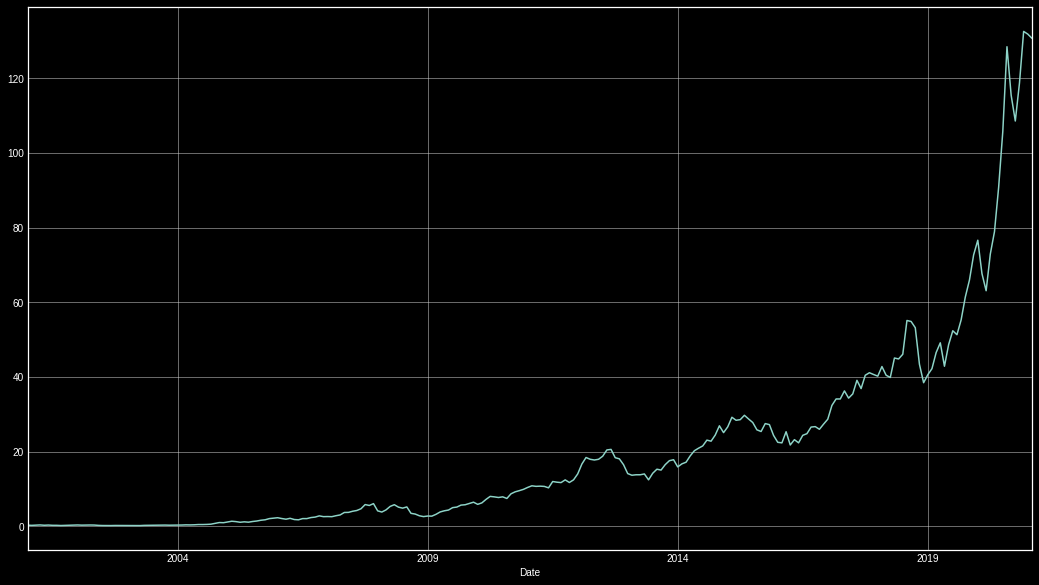

In [ ]:
aapl_close = aapl_stock['Adj Close']
ax = aapl_close.plot(figsize=(18,10))
plot_grid()

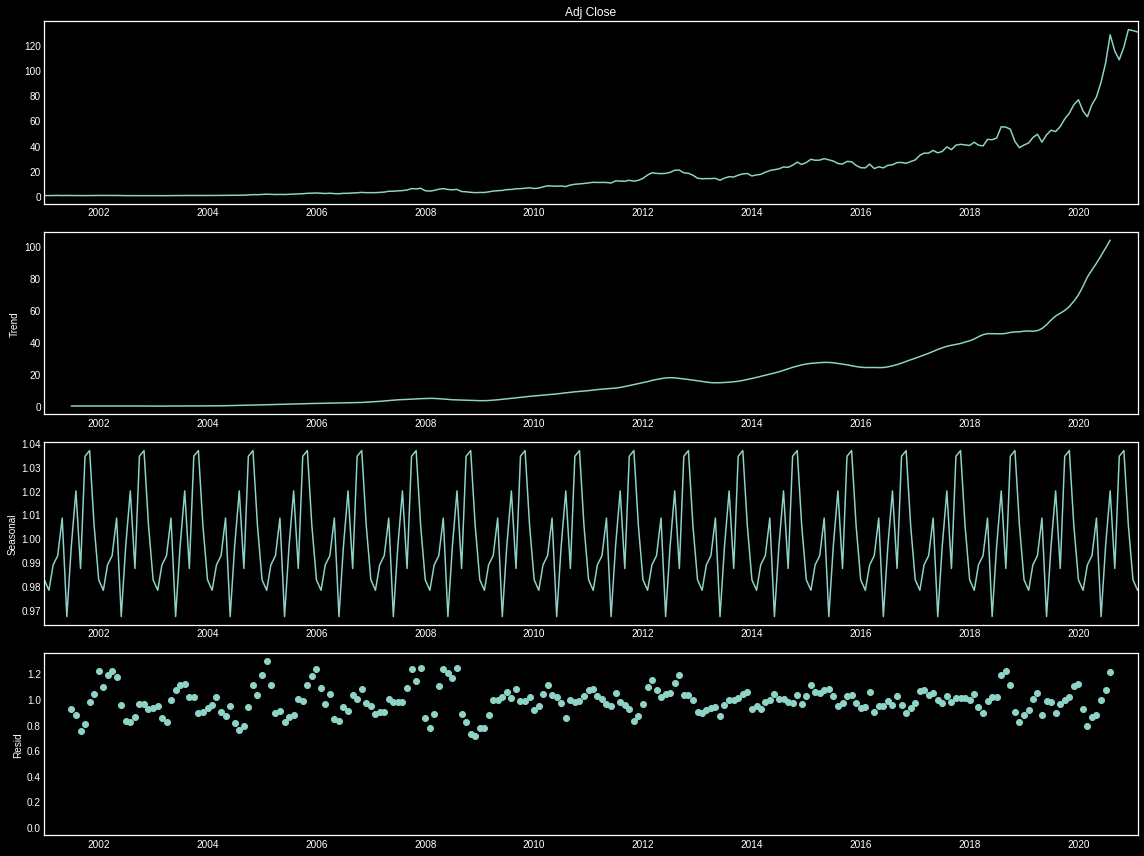

In [ ]:
# decompose dataset
dec = sm.tsa.seasonal_decompose(aapl_close, model="multiplicative")
decplot = dec.plot()

> ## 1.3 Stationarize the Data Set
* Stationarize and detrending with 3 method
* Provide compelling evidence with ADF
* Compare performances for all 3 methods and determine the best solution


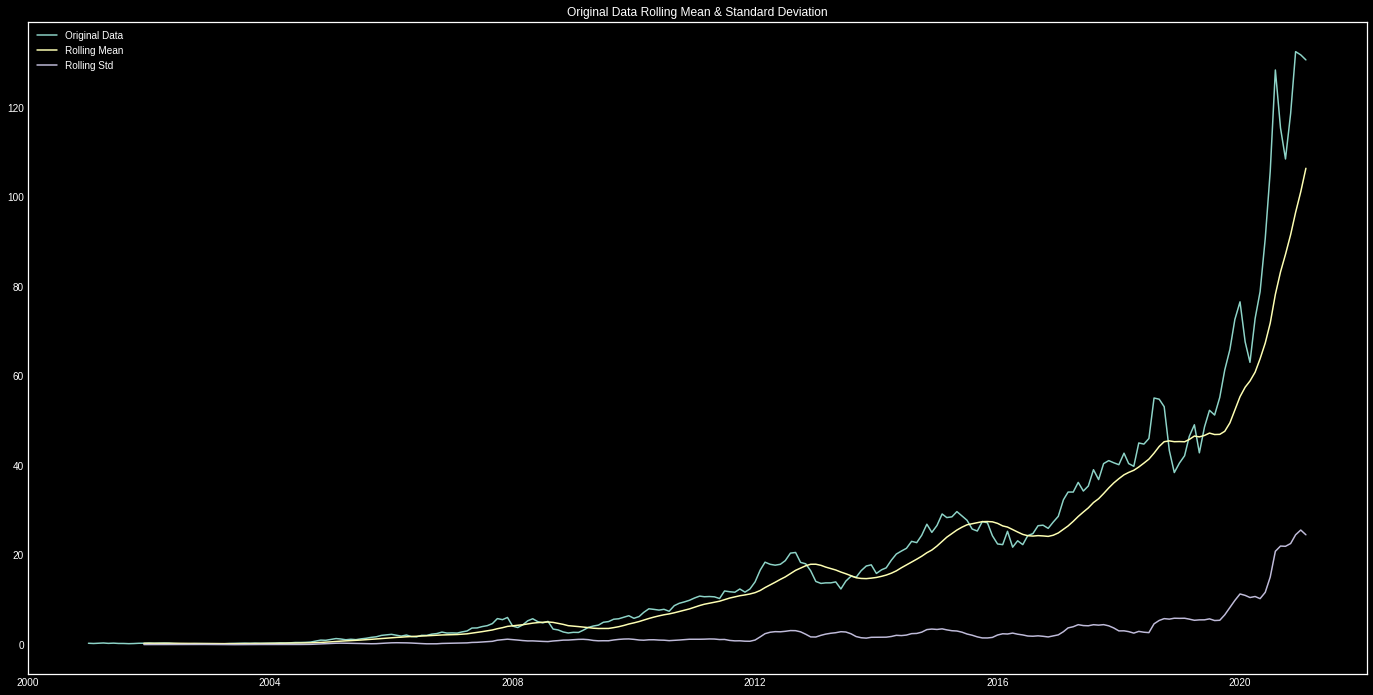

In [ ]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(24, 12))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='Rolling Mean');
    ax.plot(rolstd, label='Rolling Std');
    ax.legend()
    plt.title('{} Rolling Mean & Standard Deviation'.format(title))

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(aapl_close,'Original Data')

In [ ]:
# ADF Test

def ADF_test(timeseries, dataDesc):
    print('Results of ADF of {}:'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.5f}'.format(dftest[1]))
    print('Critical Values :')
    for key,value in dftest[4].items():
      print('\t{} : {:.3f} - The data {} stationary with {}% confidence'.format(key, value, 'is not' if value<dftest[0] else 'is', 100-int(key[:-1])))

ADF_test(aapl_close,'Original Data')

Results of ADF of Original Data:
Test statistic = 3.394
P-value = 1.00000
Critical Values :
	1% : -3.459 - The data is not stationary with 99% confidence
	5% : -2.874 - The data is not stationary with 95% confidence
	10% : -2.573 - The data is not stationary with 90% confidence


**The ADF Test Statistic is far from the critical values and the p-value is greater than the threshold (0.05), which also indicates that this the time series is not stationary.**

**In order to simply lower the increasing rate of the rolling mean, next we are going to take the log of the dependent variable.**

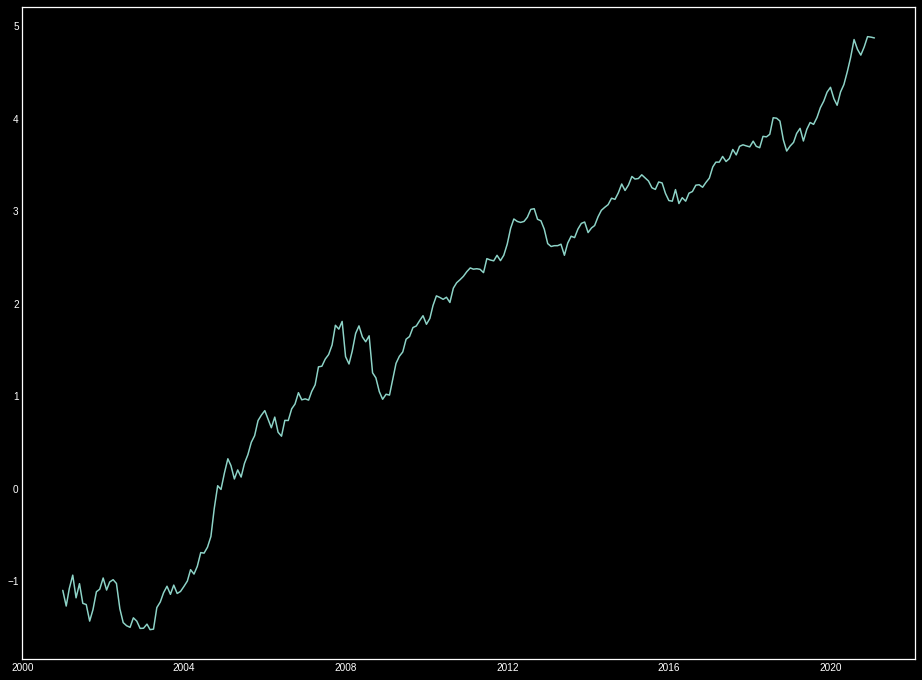

In [ ]:
# take log of the dependent variable
aapl_close_log = np.log(aapl_close)
plt.plot(aapl_close_log)

**Stationarize Time Series - Method 1**
* Subtracting Rolling Mean

Results of ADF of Stationarized Data:
Test statistic = -4.120
P-value = 0.00090
Critical Values :
	1% : -3.459 - The data is stationary with 99% confidence
	5% : -2.874 - The data is stationary with 95% confidence
	10% : -2.574 - The data is stationary with 90% confidence


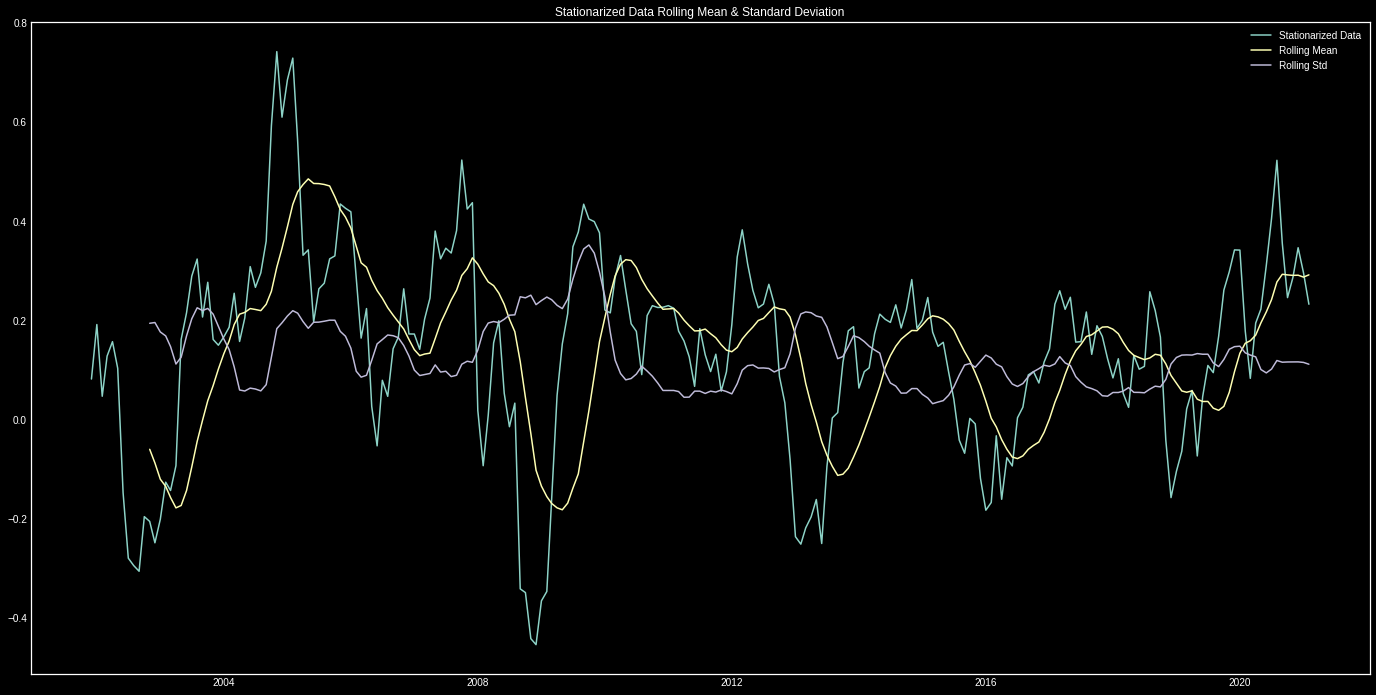

In [ ]:
# stationarize time series
rolling_mean = aapl_close_log.rolling(window=12).mean()
aapl_close_log_subtract = aapl_close_log - rolling_mean
aapl_close_log_subtract.dropna(inplace=True)

test_stationarity(aapl_close_log_subtract,'Stationarized Data')
ADF_test(aapl_close_log_subtract,'Stationarized Data')

**Stationarize Time Series - Method 2**
* Applying exponential decay

Results of ADF of Stationarized Data:
Test statistic = -2.935
P-value = 0.04143
Critical Values :
	1% : -3.458 - The data is not stationary with 99% confidence
	5% : -2.874 - The data is stationary with 95% confidence
	10% : -2.573 - The data is stationary with 90% confidence


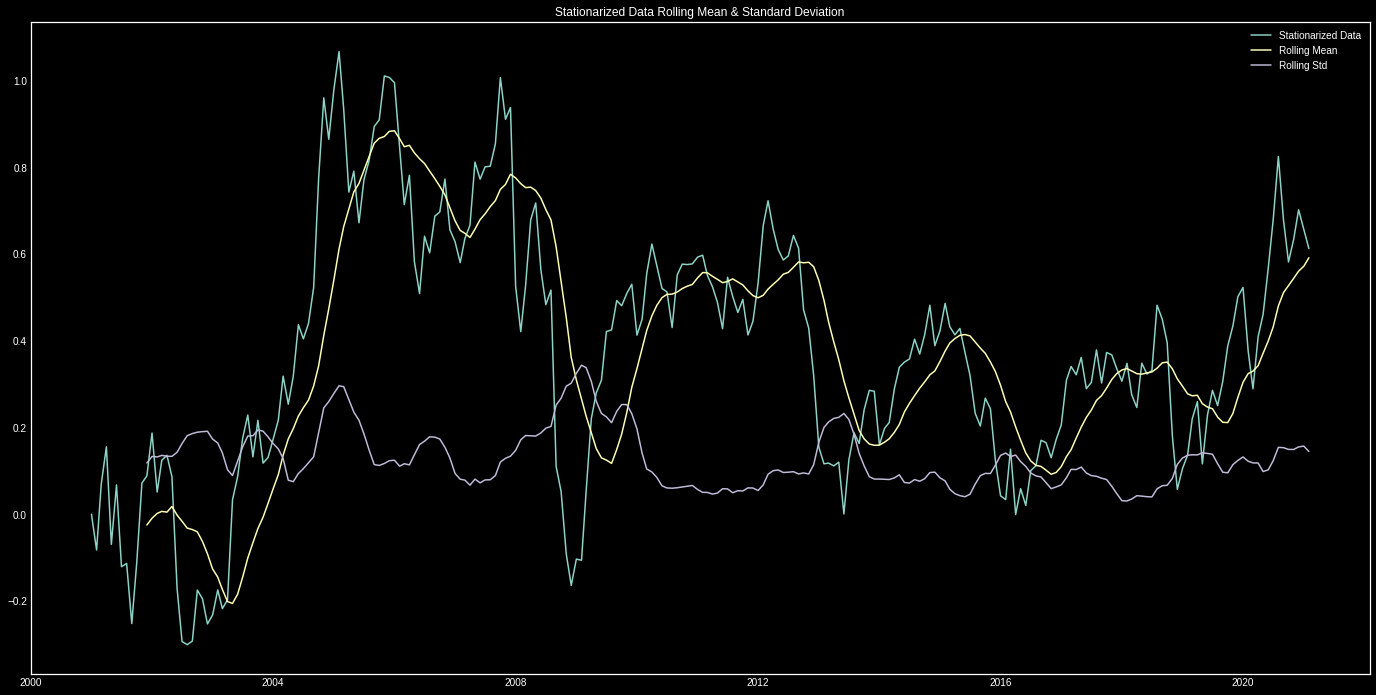

In [ ]:
rolling_mean_exp_decay = aapl_close_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
aapl_close_log_exp_decay = aapl_close_log - rolling_mean_exp_decay
aapl_close_log_exp_decay.dropna(inplace=True)

test_stationarity(aapl_close_log_exp_decay,"Stationarized Data")
ADF_test(aapl_close_log_exp_decay,"Stationarized Data")

**Stationarize Time Series - Method 3**
* Applying time shift

Results of ADF of Stationarized Data:
Test statistic = -14.250
P-value = 0.00000
Critical Values :
	1% : -3.458 - The data is stationary with 99% confidence
	5% : -2.874 - The data is stationary with 95% confidence
	10% : -2.573 - The data is stationary with 90% confidence


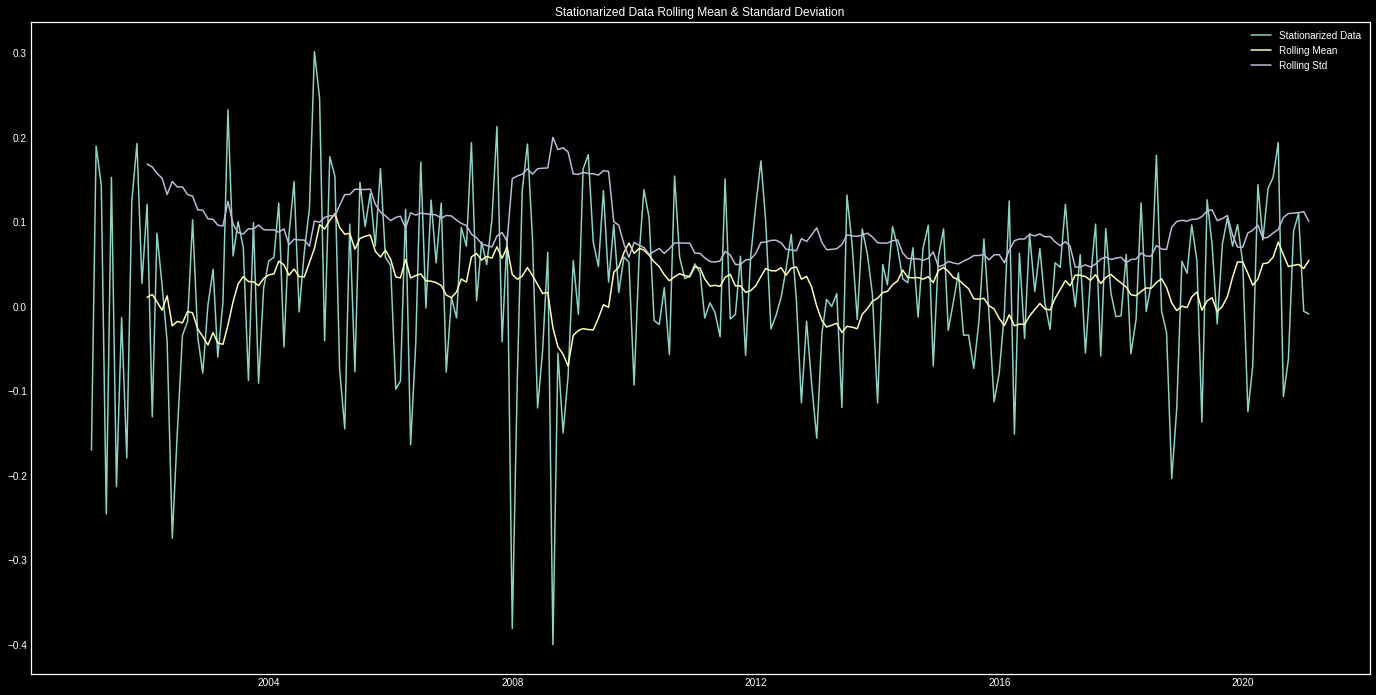

In [ ]:
aapl_close_log_shift = aapl_close_log - aapl_close_log.shift()
aapl_close_log_shift.dropna(inplace=True)

test_stationarity(aapl_close_log_shift,"Stationarized Data")
ADF_test(aapl_close_log_shift,"Stationarized Data")

**Stationarize Time Series - Method 4**
* Apply diffferencing to remove trend and seasonality

Results of ADF of Stationarized Data:
Test statistic = -7.181
P-value = 0.00000
Critical Values :
	1% : -3.461 - The data is stationary with 99% confidence
	5% : -2.875 - The data is stationary with 95% confidence
	10% : -2.574 - The data is stationary with 90% confidence


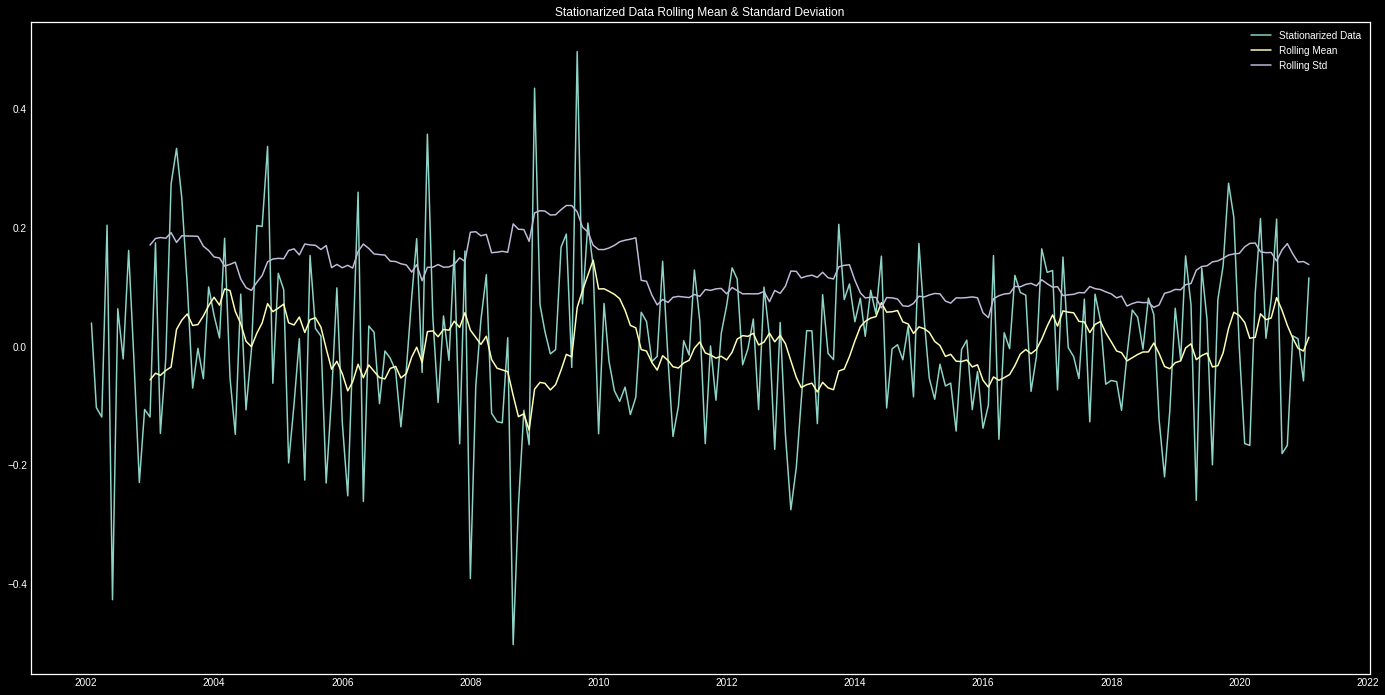

In [ ]:
aapl_close_log_diff = aapl_close_log.diff().diff(12).dropna()

test_stationarity(aapl_close_log_diff,"Stationarized Data")
ADF_test(aapl_close_log_diff,"Stationarized Data")

**Commentary:**

All three approaches somewhat makes the data more stationary than the original. But after comparing all three transformations on the time series, we could determine that applying time shift gives the best performance, the differencing method is also a fair call, and the exponential decay is the least performed method among all.

As we can see visually and throughout the statistics, after applying time shift, as well as after differencing, the rolling mean and the standard deviation are much more flat and approximately horizontal. P-value is much smaller than the threshold of 0.05 and the ADF statistics is much lower than the critical values.

In [ ]:
#aapl_close_log_shift_12lag = aapl_close_log_shift - aapl_close_log_shift.shift(12)

#test_stationarity(aapl_close_log_shift_12lag,'12 lag differenced de-trended data')
#ADF_test(aapl_close_log_shift_12lag,'12 lag differenced de-trended data')

# 2. Data Analysis Part 1 - ARIMA


> ## 2.1 Fit an ARIMA Model to the Data


In [ ]:
# apply ARIMA for time-series forcasting
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore")
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(aapl_close,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue


In [ ]:
model_output.sort_values(by = 'results.aic').head(5)

,parameters,results.aic
59,"ARIMA(1, 1, 1)x(0, 1, 1, 12)12",1113.40497772
27,"ARIMA(0, 1, 1)x(0, 1, 1, 12)12",1114.02157466
63,"ARIMA(1, 1, 1)x(1, 1, 1, 12)12",1114.20822964
31,"ARIMA(0, 1, 1)x(1, 1, 1, 12)12",1115.39578081
43,"ARIMA(1, 0, 1)x(0, 1, 1, 12)12",1116.63336236


In [ ]:
#Fit the model with the lowest AIC above

mod_1 = sm.tsa.statespace.SARIMAX(aapl_close,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod_1.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2169      0.083     -2.601      0.009      -0.380      -0.053
ma.L1          0.5402      0.079      6.805      0.000       0.385       0.696
ma.S.L12      -0.7475      0.077     -9.651      0.000      -0.899      -0.596
sigma2         9.8101      0.369     26.621      0.000       9.088      10.532


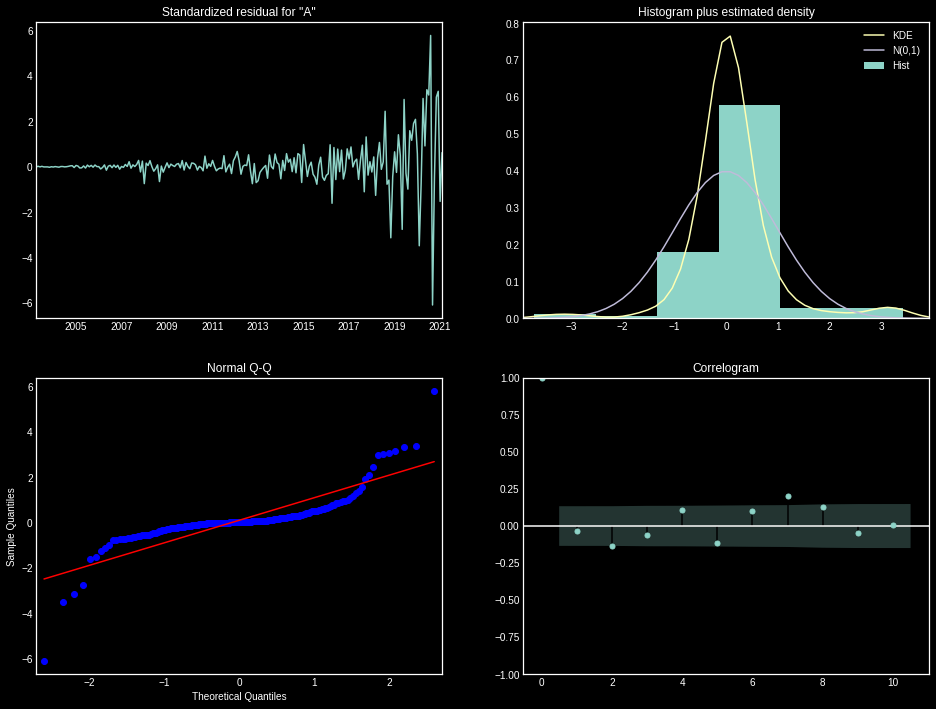

In [ ]:
results.plot_diagnostics()
plt.show()

> ## 2.2 Tuning ARIMA Model's Parameters
*  Using ACF & PACF charts for tuning

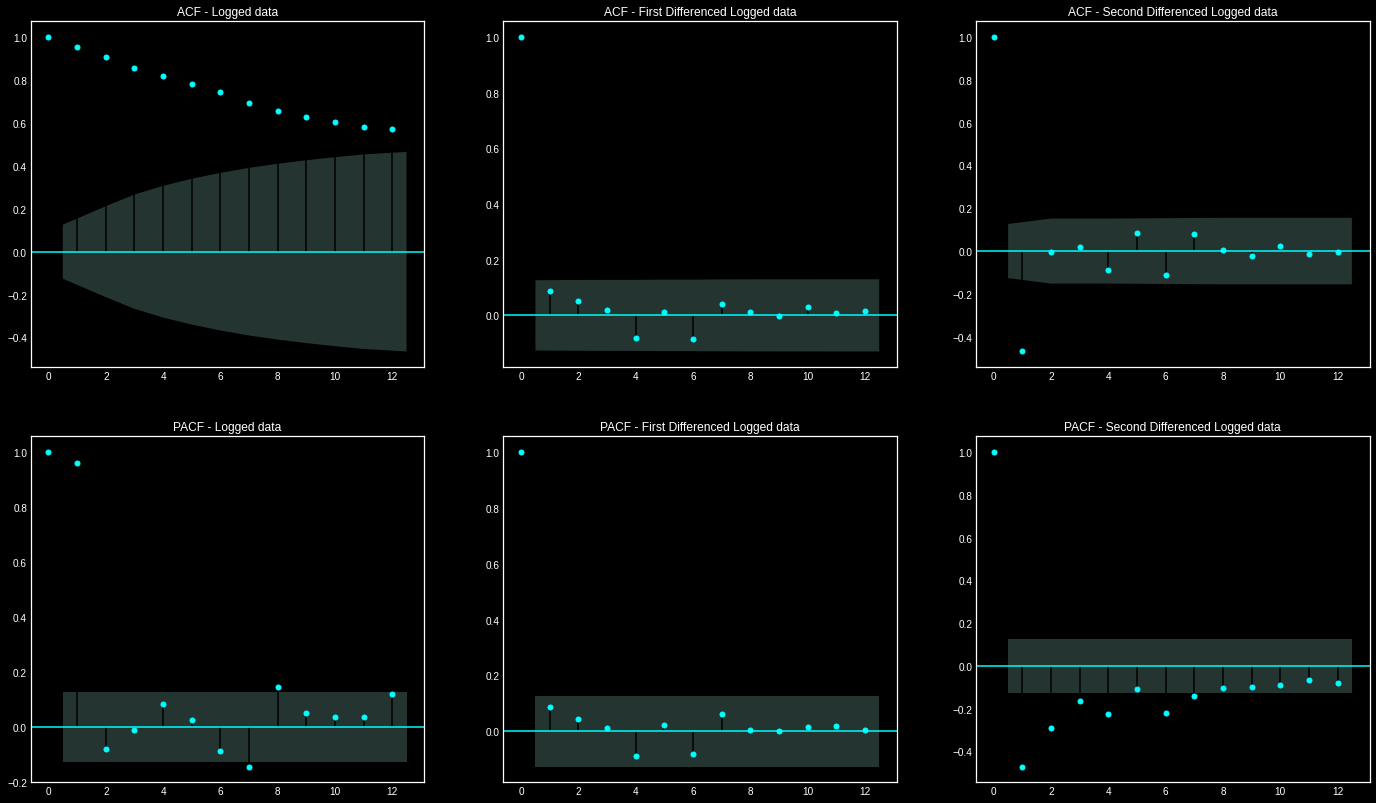

In [ ]:
# the data we are using has already been logged

fig, ax = plt.subplots(2, 3, figsize=(24,14))
first_diff = (np.log(aapl_close)- np.log(aapl_close).shift()).dropna()
second_diff = (first_diff - first_diff.shift()).dropna()

ax[0, 0] = plot_acf(aapl_close, ax=ax[0, 0], lags=12, color="cyan", title="ACF - Logged data")
ax[1, 0] = plot_pacf(aapl_close, ax=ax[1, 0], lags=12, color="cyan", title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=12, color="cyan", title="ACF - First Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=12, color="cyan", title="PACF - First Differenced Logged data")
ax[0, 2] = plot_acf(second_diff , ax=ax[0, 2], lags=12, color="cyan", title="ACF - Second Differenced Logged data")
ax[1, 2] = plot_pacf(second_diff, ax=ax[1, 2], lags=12, color="cyan", title="PACF - Second Differenced Logged data")

**Tuning ARIMA Model by determine p,d,q based on the ACF and PACF charts**
*   Since the first order differencing made it statioary. Thus, d (integral) = 1
*  AR (p) is determined by looking at PACF chart. In this case, within 2 lags AR is significant. Therefore, p = 2
*  In terms of MA, I started testing from 0, and ended up with 1 which give the best ARIMA model results


In [ ]:
# define & evaluate model
model = SARIMAX(aapl_close,
                order=(2,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  242
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -580.786
Date:                            Fri, 19 Feb 2021   AIC                           1171.571
Time:                                    05:08:21   BIC                           1188.740
Sample:                                01-01-2001   HQIC                          1178.498
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0306      0.106      0.289      0.772      -0.177       0.238
ar.L2         -0.2258      0.042     -5.373      0.000      -0.308      -0.143
ma.L1          0.2632      0.096      2.753      0.006       0.076       0.451
ma.S.L12      -0.6913      0.061    -11.333      0.000      -0.811      -0.572
sigma2         9.0200      0.310     29.123      0.000       8.413       9.627
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1925.16
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             182.61   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

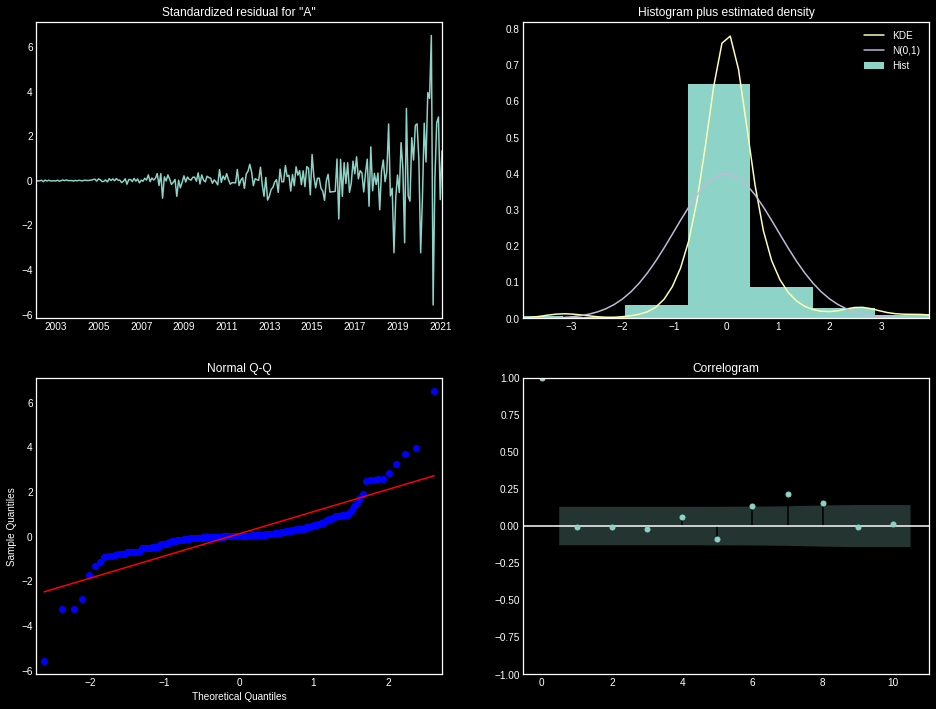

In [ ]:
results.plot_diagnostics()
plt.show()

> ## 2.3 Data Forcasting


In [ ]:
#train_df, test_df = aapl_close[0:int(len(aapl_close)*0.8)].dropna(), aapl_close[int(len(aapl_close)*0.8):].dropna()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

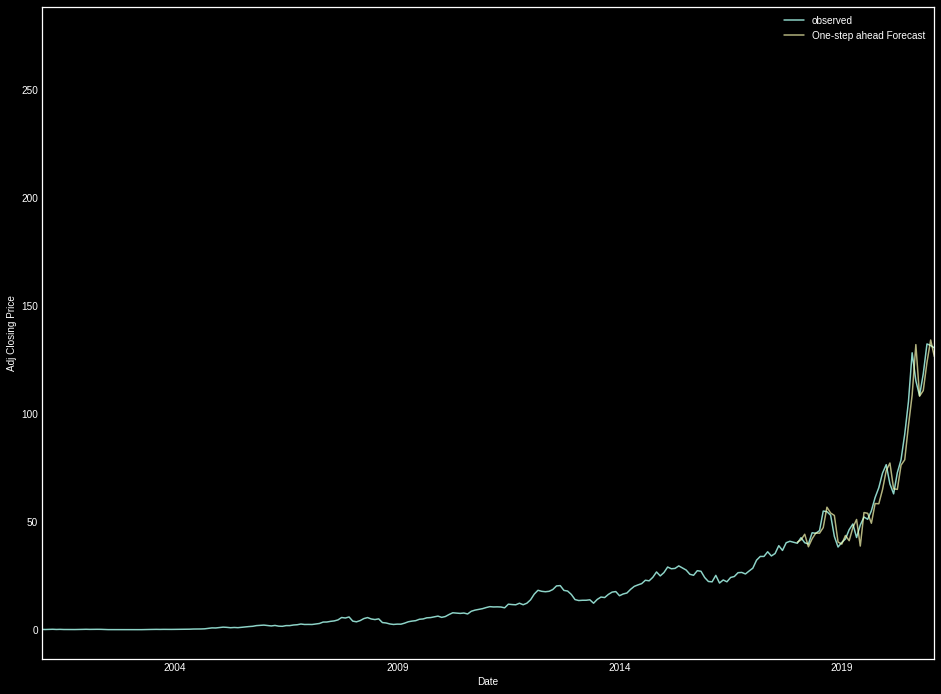

In [ ]:
ax = aapl_close.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='lightgrey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Adj Closing Price')
plt.legend()

In [ ]:
#Performance Criteria
aapl_close_forecasted = pred.predicted_mean
aapl_close_actual = aapl_close['2018-01-01':]

# Compute the mean square error
mse = ((aapl_close_forecasted - aapl_close_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

#print('Accuracy Score of our forecast is ', accuracy_score(aapl_close_actual,aapl_close_forecasted))

The Mean Squared Error of our forecasts is 6.9


In [ ]:
#Prepare for a forecast

# Get forecast 30 steps ahead in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

df_forecasted = pred_uc.predicted_mean

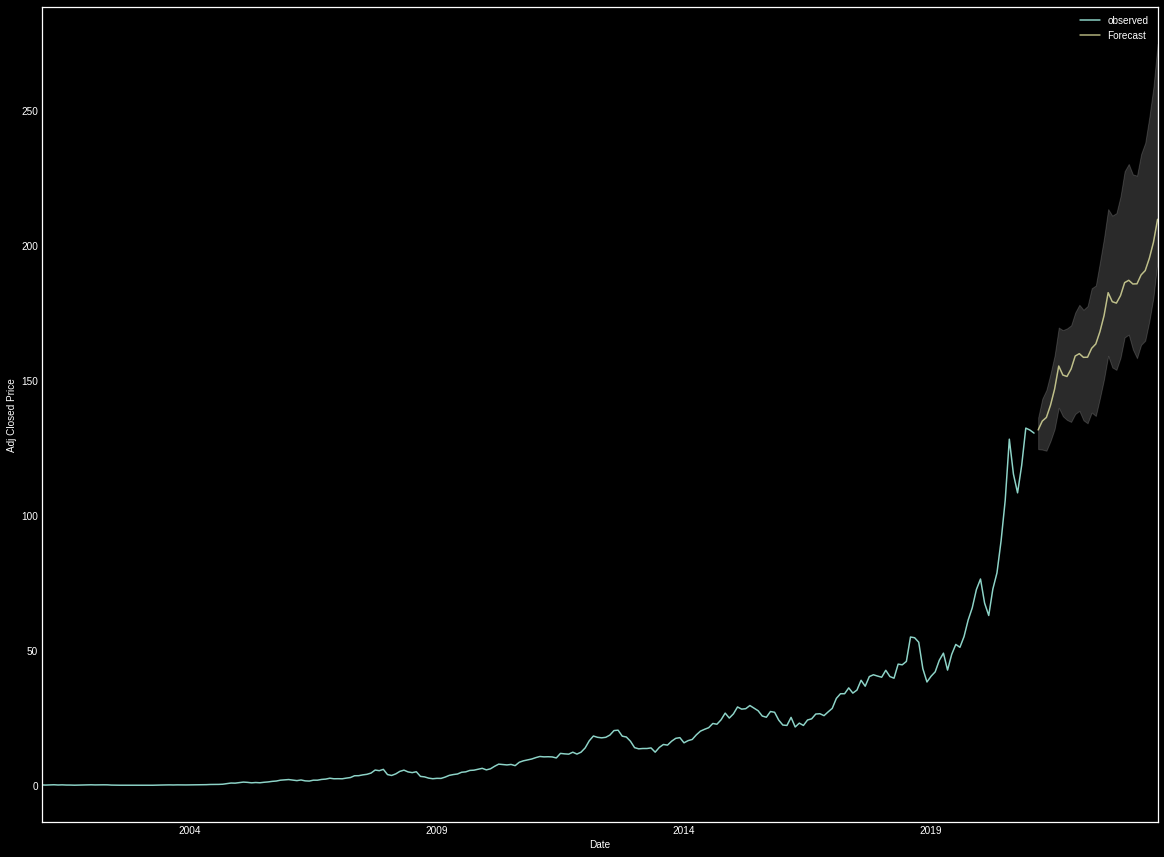

In [ ]:
ax = aapl_close.plot(label='observed', figsize=(20, 15))
df_forecasted.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='lightgrey', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Adj Closed Price')

plt.legend()

# 3. Data Analysis Part 2


> ## 3.1 Search for Other Parameters
**Two Approaches**
*  Approach 1 - Using SARIMA Grid Search to iteratively explore for better combination of parameters
*  Approach 2 - Using the built in auto ARIMA function


>### 3.1.1 Approach 1 - Grid Search & Performance Measures

In [ ]:
def sarima_grid_search(aapl_close,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(aapl_close,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                #print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(aapl_close,12)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1113.4049777205896


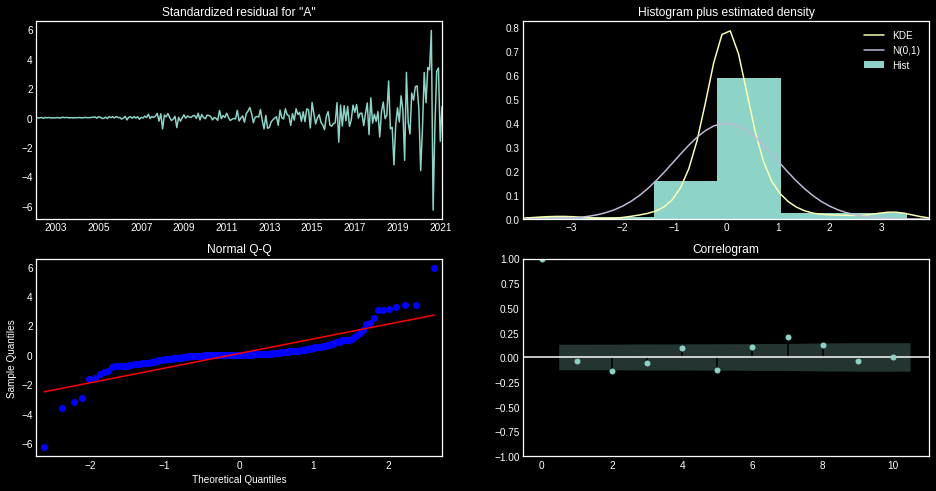

In [ ]:
# After picking the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(aapl_close,order,seasonal_order,seasonal_period,pred_date,df_to_test):

# fit the model 
  model = sm.tsa.statespace.SARIMAX(aapl_close,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

  results = model.fit()
  print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()


In [ ]:
model_1 = sarima_eva(aapl_close,(1, 1, 1),(0, 1, 1, 12),12,'2018-01-01',aapl_close)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2169      0.083     -2.601      0.009      -0.380      -0.053
ma.L1          0.5402      0.079      6.805      0.000       0.385       0.696
ma.S.L12      -0.7475      0.077     -9.651      0.000      -0.899      -0.596
sigma2         9.8101      0.369     26.621      0.000       9.088      10.532


In [ ]:
model_1 = SARIMAX(aapl_close,
                order=(1,1,1),seasonal_order=(0,1,1,12))
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  242
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -584.055
Date:                            Fri, 19 Feb 2021   AIC                           1176.110
Time:                                    05:24:07   BIC                           1189.845
Sample:                                01-01-2001   HQIC                          1181.651
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2273      0.075     -3.020      0.003      -0.375      -0.080
ma.L1          0.5485      0.072      7.583      0.000       0.407       0.690
ma.S.L12      -0.7111      0.069    -10.234      0.000      -0.847      -0.575
sigma2         9.2580      0.325     28.498      0.000       8.621       9.895
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1994.56
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):             195.95   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_1 = results_1.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#Performance Criteria
aapl_close_forecasted_1 = pred_1.predicted_mean
aapl_close_actual = aapl_close['2018-01-01':]

# Compute the mean square error
mse = ((aapl_close_forecasted_1 - aapl_close_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 7.04


> ### 3.1.2 Approach 2 - Auto ARIMA & Performance Measures

In [ ]:
model_2 = pm.auto_arima(aapl_close, start_p=0, start_d=1, start_q=0,
                       test='adf', max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, D=1, trace=True, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)

model_2.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1195.660, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1247.185, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1196.232, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1177.187, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1233.292, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1177.592, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1177.487, Time=0.88 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1187.740, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1179.475, Time=2.69 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1176.110, Time=0.54 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1228.352, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1176.268, Time=0.84 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1176.110, Time=1.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1183.937, Time=0.28 sec
 ARIMA(1,1,1)(1,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  242
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -577.208
Date:                            Fri, 19 Feb 2021   AIC                           1166.417
Time:                                    05:19:13   BIC                           1187.019
Sample:                                         0   HQIC                          1174.728
                                            - 242                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4073      0.268      1.521      0.128      -0.118       0.932
ar.L1          0.2561      0.034      7.567      0.000       0.190       0.322
ar.L2         -0.2959      0.041     -7.230      0.000      -0.376      -0.216
ar.S.L12      -0.7540      0.041    -18.510      0.000      -0.834      -0.674
ar.S.L24      -0.4066      0.099     -4.106      0.000      -0.601      -0.213
sigma2         8.7196      0.366     23.821      0.000       8.002       9.437
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1310.86
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):             111.25   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_2_test = sarima_eva(aapl_close,(2, 1, 0),(2, 1, 0, 12),12,'2018-01-01',aapl_close)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2825      0.036      7.795      0.000       0.211       0.354
ar.L2         -0.2800      0.043     -6.586      0.000      -0.363      -0.197
ar.S.L12      -0.8462      0.045    -18.679      0.000      -0.935      -0.757
ar.S.L24      -0.6054      0.116     -5.228      0.000      -0.832      -0.378
sigma2         9.9111      0.420     23.597      0.000       9.088      10.734


In [ ]:
model_2 = SARIMAX(aapl_close,
                order=(2,1,0),seasonal_order=(2,1,0,12))
results_2 = model_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  242
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -579.144
Date:                            Fri, 19 Feb 2021   AIC                           1168.288
Time:                                    05:29:39   BIC                           1185.456
Sample:                                01-01-2001   HQIC                          1175.214
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2681      0.033      8.184      0.000       0.204       0.332
ar.L2         -0.2836      0.038     -7.422      0.000      -0.359      -0.209
ar.S.L12      -0.7443      0.040    -18.602      0.000      -0.823      -0.666
ar.S.L24      -0.4032      0.095     -4.237      0.000      -0.590      -0.217
sigma2         8.8755      0.333     26.617      0.000       8.222       9.529
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1280.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             187.49   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_2 = results_2.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#Performance Criteria
aapl_close_forecasted_2 = pred_2.predicted_mean
aapl_close_actual = aapl_close['2018-01-01':]

# Compute the mean square error
mse = ((aapl_close_forecasted_2 - aapl_close_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 6.85


> ## 3.2 Model Comparison


**Overlook of the parameters of all models**

*  Original Model: (1,1,1),(0,1,1,12)
*  Tunned Original Model: (2,1,1),(0,1,1,12)
*  First - Grid Search Model: (1,1,1),(0,1,1,12)
*  Second - Auto ARIMA Model: (2,1,0),(2,1,0,12)

FIrst comparing the two new models within this secion. Both have pretty similar performance output, with the second model to be slightly more accurate than the first. And the tunned original model falls somewhere in between, and the original model happend to be exactly the same as the grid search (first) model.

The second model has a smaller MSE (6.85) comparing to the 6.9 MSE of the tunned original model and the 7.04 MSE of the first model.

The AIC value of the second model (1168.288) is also slightly smaller than the 1171.571 of the tunned orginal model and the 1176.11 of the first model.

Both values above indicate that the second model, which uses auto ARIMA to find the parameters, has a better performance than the tunned original model, as well as the first model, which utilized grid search to find the parameters provides the worst performance among all three.

Thus we can conclude that the most optimized combination of SARIMA parameters we could find so far is (p,d,q) = (2,1,0), and (P,D,Q)m = (2,1,0)12. 

Next, we are going to look at how well the two new models provides visual predictions and forcast.

> ## 3.3 Forecast with New Models

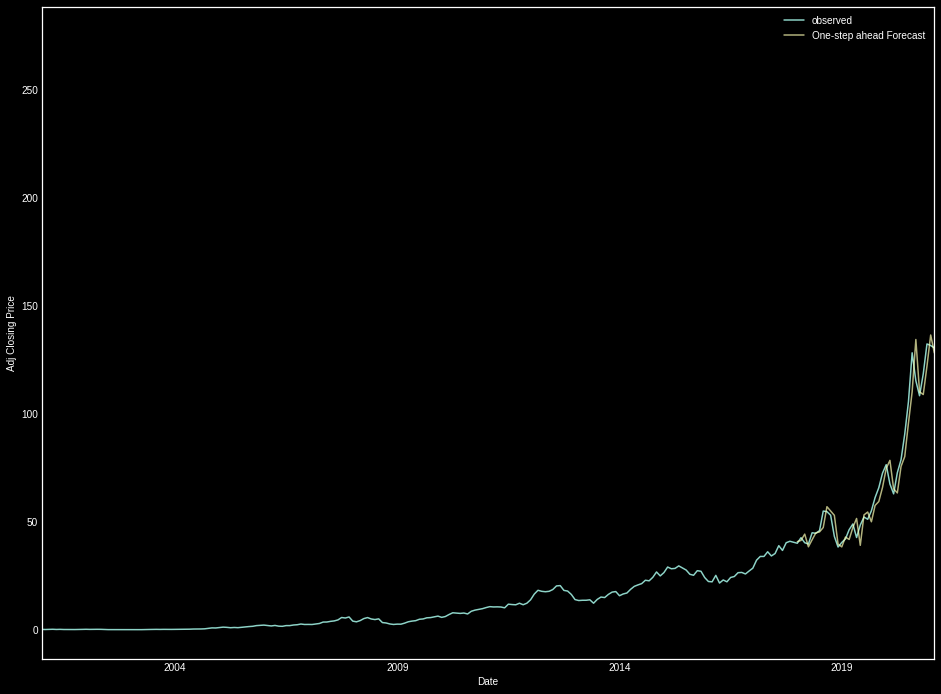

In [ ]:
ax = aapl_close.plot(label='observed')
pred_1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='orange', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Adj Closing Price')
plt.legend()

In [ ]:
#Prepare for a forecast

# Get forecast 200 steps ahead in future
pred_uc = results_1.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

df_forecasted_1 = pred_uc.predicted_mean

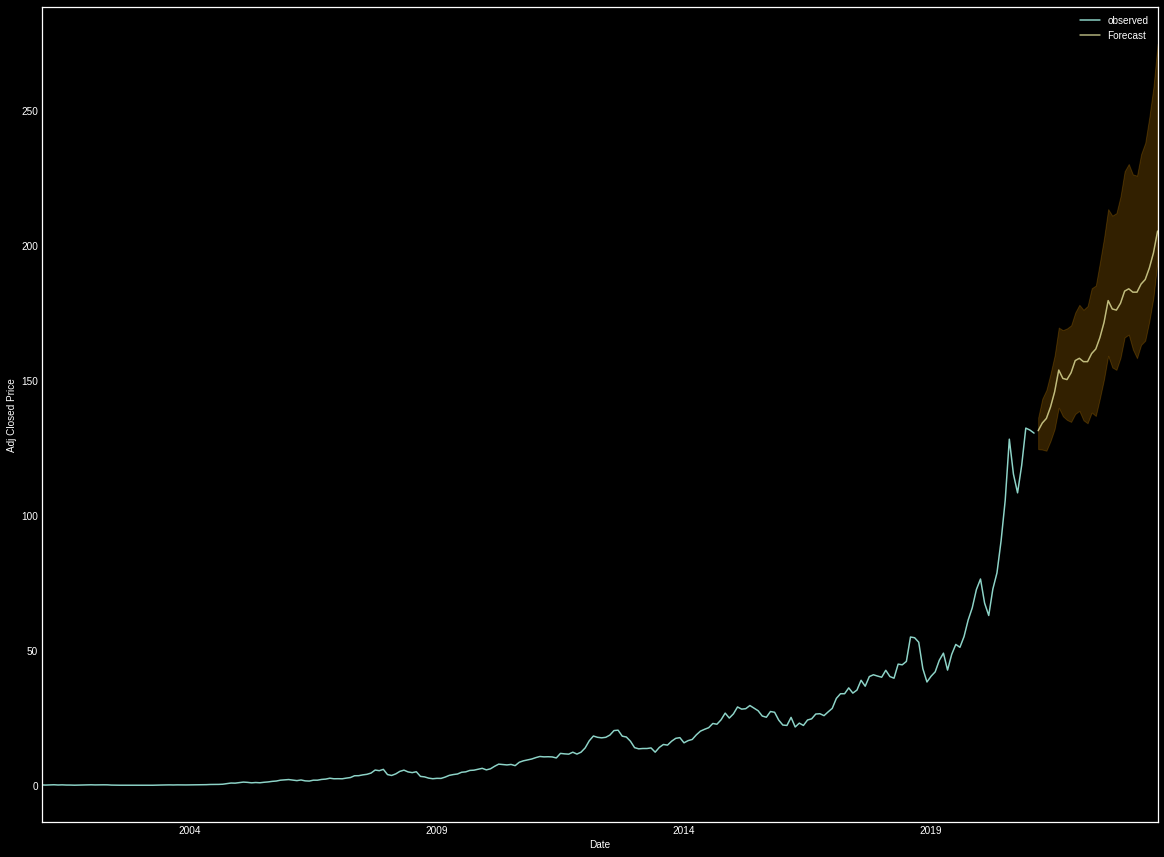

In [ ]:
ax = aapl_close.plot(label='observed', figsize=(20, 15))
df_forecasted_1.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='orange', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Adj Closed Price')

plt.legend()

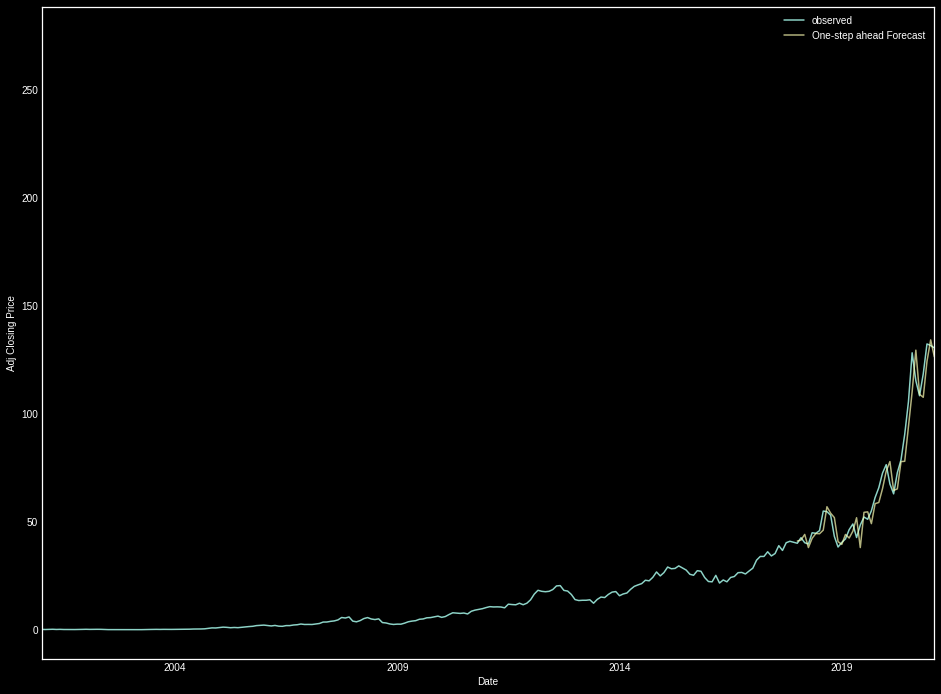

In [ ]:
ax = aapl_close.plot(label='observed')
pred_2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='orange', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Adj Closing Price')
plt.legend()

In [ ]:
#Prepare for a forecast

# Get forecast 200 steps ahead in future
pred_uc = results_2.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

df_forecasted_2 = pred_uc.predicted_mean

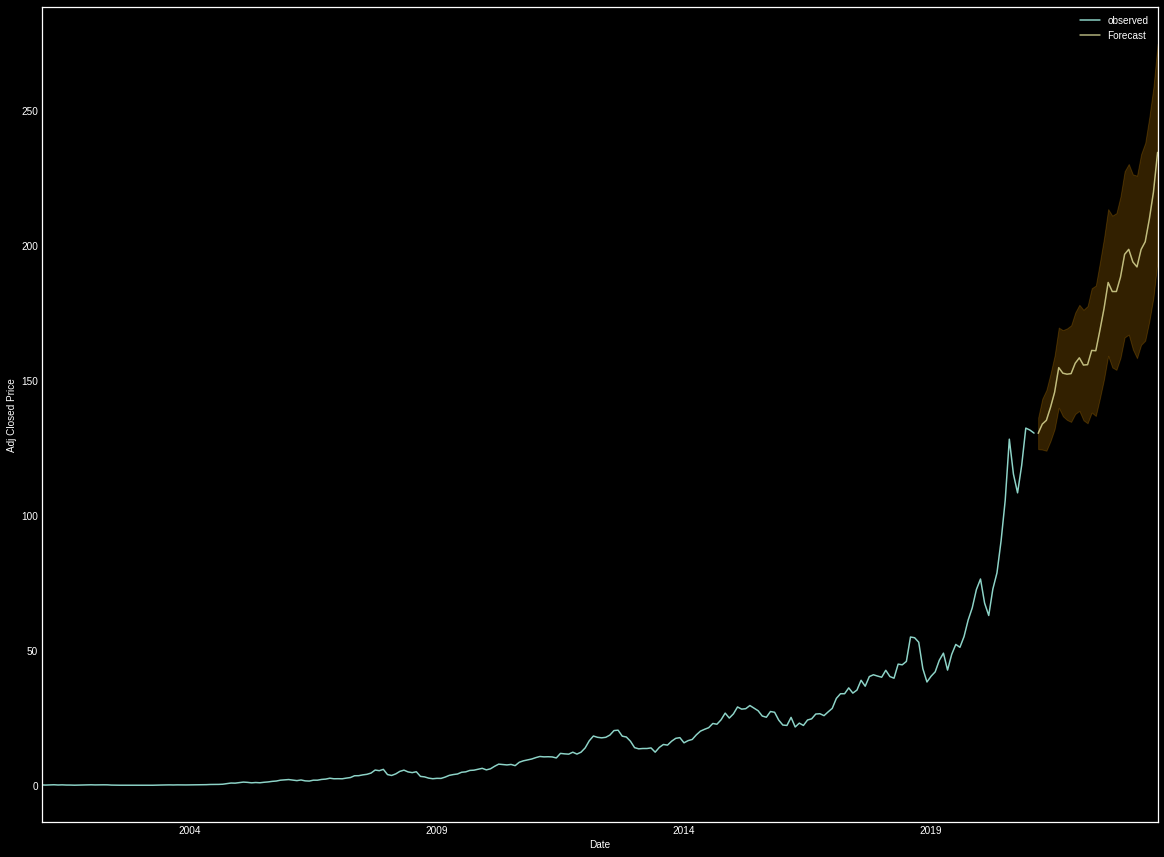

In [ ]:
ax = aapl_close.plot(label='observed', figsize=(20, 15))
df_forecasted_2.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='orange', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Adj Closed Price')

plt.legend()

> ## 3.4 Model Forecast Comparison



The graphs above are set up the same way as for the original model: firstly, to predict the trend for the test data set; secondly, to get forcast of the adjusted closing stock price of Apple Inc. for the next 30 months.

From the graphs above we can tell that the grid search (first) model gives very similar prediction and forcast results as the tunned original model, which makes sense, since they have very close results of parameters.

The auto ARIMA (second) model, on the other hand, have slight difference in both predictions and forecast than the other two. Looking closely at the prediction plot for 2018-01-01 and after, the auto ARIMA model generates a trend line that is closer to the actual trend, just with a slight shift in time. This outcome also supports the conclusion that the auto ARIMA (second) model is a bit accurate thn the other two. and the forecast for the 30 months in the furture has a tiny more upward trend than the othe two models.

# 4. Data Analysis Part 3


> ## 4.1 Commentary with Impact and Takeaways

Although there are many more factors affacting the stock price and no one or no single model could perfectly predict the furture stock price, but it gives us a general sense, and it is great for us to compare between models and find the more accurate one(s).

All three of my model's forecast predicted the Apple stock price with a pretty steep upward trend. There will be some fluctuation and drops towards the end of 2021 and 2022, but goes back up pretty rapidly throught the begining of the upcoming year.

A couple of insights and takeaways are as follows:

* It is important to stationarize the model before further analysis.
* There are multiple ways to stationarize a model, it is worthy to run a test for each stationarized method to determine the most suitable way.
* You will need a stationarized dataset to work with ARMA. But since ARIMA has that "I" feature in there, it could handle somewhat non-stationary models, so we could probably stick with the original data.
* Tunning the model with ACF and PACF, after we figured out a possible combination of ARIMA parameters would be helpful.
* The auto ARIMA function tends to work pretty well in finding the best combination of parameters for prediction and forecasting model.